In [13]:
import os
import sys

cwd0 = '../config/'
sys.path.append(cwd0)

import visualID as vID
from visualID import color
vID.init(cwd0)

**Début à:** Thursday 03 November 2022, 21:41:30  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="../config/svg/logoDebut.svg" style="margin-left:auto; margin-right:auto"/></p>

### **Exercice.** Apprentissage supervisé (*supervised Machine Learning*) appliqué à la classification.<br>Corrigé

On a développé dans le cours un algorithme de reconnaissance basé sur deux caractéristiques, les **longueur et largeur des pétales** d'iris. L'exercice qui est proposé ici vise à développer un algorithme capable d'établir une corrélation plus complexe, en prenant simultanément en compte les **longueurs et largeurs des pétales et des sépales**.

<p><img width="450px" src="../DS4B-svg/IA-petales-sepales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_IA_jpc"/></p>  

Et on va voir que ça permet effectivement de diminuer l'erreur commise. On conviendra que ça devient plus compliqué pour nos cerveaux de rechercher si les corrélations croisées, reportées dans la figure ci-dessous, permettent une meilleure classification. C'est pour ce type de tâche, au-delà de corrélations simples, que l'utilisation de ces algorithmes prend tout son sens. 

<div class="warn">

**<span style="color:red">Vous êtes encouragés à "tricher" &#128578; ! </span>**, c'est-à-dire à vous inspirer du [notebook de cours](../DS4B-Iris3.ipynb), dont le code n'a qu'à être légèrement adapté pour accepter quatre informations en entrée au lieu de deux seulement.

</div>

#### Importation des modules utiles

In [14]:
# exécutez cette cellule, sans la modifier
%matplotlib inline
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

#### **Exercice 1.** Lecture, analyse et adaptation des données

##### **1.** Lecture de la base de données qui ont été adaptées au problème

In [15]:
# exécutez cette commande, sans la modifier
dfi=pd.read_csv('../DS4B-iris-data/iris_ohe.csv', sep="\t") #les colonnes sont séparées par des tabulations
print(f"Dfi. Structure (shape) :{dfi.shape}")

# ajouter ci-dessous la commande permettant d'afficher le dataframe dfi - ne pas utiliser print()
display(dfi)

Dfi. Structure (shape) :(150, 8)


,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,setosa,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,setosa,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,setosa,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,setosa,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0.0,0.0,1.0
146,6.3,2.5,5.0,1.9,virginica,0.0,0.0,1.0
147,6.5,3.0,5.2,2.0,virginica,0.0,0.0,1.0
148,6.2,3.4,5.4,2.3,virginica,0.0,0.0,1.0


##### **2.** Séparation des données en deux sous-ensembles d'apprentissage et de test

Séparer le jeu de données stocké dans `dfi` en deux sous-ensembles :
- un jeu de données d'apprentissage (80% des données de `dfi`)
- un jeu de données de test, indépendantes du jeu de données d'apprentissage (20% des données de `dfi`) 

On définira 4 nouveaux dataframes, `x_train`, `x_test`, `y_train`, `y_test` qui ont pour but d'entraîner et de tester un réseau de neurones conçu pour identifier un type d'iris sur la base de 4 descripteurs : longueur et largeur des pétales & longueur et largeur des sépales. 

In [16]:
# entrez ci-dessous votre code python
data_train = dfi.sample(frac=0.8, axis='index') # on sélectionne au hasard 80% de l'échantillon
data_test  = dfi.drop(data_train.index) # on sélectionne le reste

x_train = data_train[['sepal_length','sepal_width','petal_length','petal_width']]
y_train = data_train[['setosa','versicolor','virginica']]
y_train_species = data_train[['species']] #sera utile à la fin pour comparer la prédiction et l'espèce réelle

x_test  = data_test[['sepal_length','sepal_width','petal_length','petal_width']]
y_test  = data_test[['setosa','versicolor','virginica']]
y_test_species = data_test[['species']] #sera utile à la fin pour comparer la prédiction et l'espèce réelle

print('x_train : ',x_train.shape)
display(x_train)
print('y_train : ',y_train.shape,'y_train_species : ',y_train_species.shape)
display(y_train, y_train_species)

x_train :  (120, 4)


,sepal_length,sepal_width,petal_length,petal_width
122,7.7,2.8,6.7,2.0
107,7.3,2.9,6.3,1.8
63,6.1,2.9,4.7,1.4
103,6.3,2.9,5.6,1.8
149,5.9,3.0,5.1,1.8
...,...,...,...,...
100,6.3,3.3,6.0,2.5
43,5.0,3.5,1.6,0.6
141,6.9,3.1,5.1,2.3
68,6.2,2.2,4.5,1.5


y_train :  (120, 3) y_train_species :  (120, 1)


,setosa,versicolor,virginica
122,0.0,0.0,1.0
107,0.0,0.0,1.0
63,0.0,1.0,0.0
103,0.0,0.0,1.0
149,0.0,0.0,1.0
...,...,...,...
100,0.0,0.0,1.0
43,1.0,0.0,0.0
141,0.0,0.0,1.0
68,0.0,1.0,0.0


,species
122,virginica
107,virginica
63,versicolor
103,virginica
149,virginica
...,...
100,virginica
43,setosa
141,virginica
68,versicolor


##### **3.** Adaptation des données à la régression logistique par le réseau de neurones

On a indiqué dans le cours que toute donnée soumise à l'algorithme (c'est-à-dire toute donnée d'*entrée*) doit au préalable être standardisée à l'aide de la commande `scaler.transform()` du module `scikit learn`.

- Appliquer la procédure de façon appropriée
- Afficher les données d'apprentissage après standardisation
- Faire de même pour les données de test si vous leur avez appliqué la standardisation 


In [17]:
# entrez ci-dessous votre code python
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
x_trainS = scaler.transform(x_train.values) #returns a numpy array
x_testS = scaler.transform(x_test.values) #returns a numpy array
x_trainD = pd.DataFrame(x_trainS, columns=x_train.columns, index=x_train.index)
x_testD = pd.DataFrame(x_testS, columns=x_test.columns, index=x_test.index)
display(x_trainD.describe().style.format("{0:.2f}").set_caption("Training set après normalisation (avec scikit-learn):"))
display(x_testD.describe().style.format("{0:.2f}").set_caption("Test set after après normalisation (avec scikit-learn):"))
x_train = x_trainS
x_test = x_testS
del x_trainD, x_testD, x_trainS, x_testS

,sepal_length,sepal_width,petal_length,petal_width
count,120.00,120.00,120.00,120.00
mean,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00
min,-1.85,-2.41,-1.64,-1.50
25%,-0.90,-0.53,-1.30,-1.24
50%,-0.06,-0.05,0.37,0.08
75%,0.65,0.47,0.73,0.86
max,2.45,3.24,1.64,1.65


,sepal_length,sepal_width,petal_length,petal_width
count,30.00,30.00,30.00,30.00
mean,-0.05,0.36,-0.28,-0.29
std,0.94,1.05,1.04,0.97
min,-1.49,-1.47,-1.53,-1.37
25%,-0.78,-0.47,-1.36,-1.37
50%,-0.36,0.42,0.02,-0.12
75%,0.48,1.12,0.49,0.44
max,2.21,2.06,1.75,1.65


#### **Exercice 2.** Définition et apprentissage du modèle

##### **1.** Définition du modèle

Définir un réseau de neurones par l'implémentation d'une fonction `get_model(NE)` adaptée, où `NE` est le nombre de neurones de la couche d'entrée, passé en paramètre.

On propose l'architecture suivante :
- une couche de neurones d'entrée
- une couche cachée de 7 neurones, activés par la fonction `relu`
- une deuxième couche cachée, de 5 neurones, eux aussi activés par la fonction `relu`
- une couche de sortie, avec le nombre de neurones approprié. On vous laisse le choix d'utiliser ou pas la fonction d'activation `softmax `

L'apprentissage se fera à l'aide de l'optimiseur `adam`, qui cherchera à minimiser la fonction `categorical_crossentropy`. On utilisera le mot-clef `accuracy` pour la métrique. 

In [18]:
# entrez ci-dessous votre code python
def get_model(NE): #NE = nombre de neurones d'entrée
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(NE, name='iLayer'))
    model.add(keras.layers.Dense(7, activation='relu', name='hLayer1'))
    model.add(keras.layers.Dense(5, activation='relu', name='hLayer2'))
    model.add(keras.layers.Dense(3, activation='softmax', name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'categorical_crossentropy',
                  metrics   = ['accuracy'] )
    return model

##### **2.** Apprentissage supervisé du réseau de neurones

C'est maitenant qu'on lance l'apprentissage. On rappelle que :
- on définit d'abord le modèle `ANNmodel=define_model( (4,)) `
- on lance son optimisation `ANNmodel.fit`
- l'algorithme (l'IA) optimal ainsi que les algorithmes intermédiaires vont être sauvegardés en tant que `ANNhistory`

In [19]:
# exécutez cette cellule, sans la modifier
vID.chrono_start()
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
print(f"x_train. Structure (shape) : {x_train.shape}")
print(f"x_test. Structure (shape) : {x_test.shape}")
print(f"y_train. Structure (shape) : {y_train.shape}")
print(f"y_test. Structure (shape) : {y_test.shape}")
ANNmodel=get_model( (4,)) # 4 neurones d'entrée
ANNmodel.summary()
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 700,
                    batch_size      = 5,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

x_train. Structure (shape) : (120, 4)
x_test. Structure (shape) : (30, 4)
y_train. Structure (shape) : (120, 3)
y_test. Structure (shape) : (30, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hLayer1 (Dense)             (None, 7)                 35        
                                                                 
 hLayer2 (Dense)             (None, 5)                 40        
                                                                 
 oLayer (Dense)              (None, 3)                 18        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________
Epoch 1/700
24/24 [==============================] - 1s 10ms/step - loss: 1.0972 - accuracy: 0.1500 - val_loss: 1.0869 - val_accuracy: 0.2333
Epoch 2/700
24/24 [=============

#### **Exercice 3.** Évaluation du modèle

##### **1.** Évaluation globale de la précision du modèle

Utiliser la fonction `evaluate` de `Keras` afin de renvoyer les valeurs des erreurs "loss" et "accuracy".

In [20]:
# entrez ci-dessous votre code python
evalANN_on_Train = ANNmodel.evaluate(x_train, y_train, verbose=0)
print(f"{color.GREEN}x_train / loss      : {evalANN_on_Train[0]:5.4f}{color.OFF}")
print(f"{color.GREEN}x_train/ accurracy  : {evalANN_on_Train[1]:5.4f}{color.OFF}")
print()
evalANN_on_Test = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(f"{color.BLUE}x_test / loss      : {evalANN_on_Test[0]:5.4f}{color.OFF}")
print(f"{color.BLUE}x_test/ accurracy  : {evalANN_on_Test[1]:5.4f}{color.OFF}")

x_train / loss      : 0.0471
x_train/ accurracy  : 0.9917

x_test / loss      : 0.0530
x_test/ accurracy  : 0.9667


##### **2.** Comportement du modèle vis-à-vis de chaque espèce d'iris

- Afficher les probailités pour chacun des échantillons du jeu d'apprentissage (`xtrain` et `y_train`).
- Les convertir en espèce d'iris grâce à `argmax` et à la liste `dfi['species'].unique()` qu'on sauvera dans une variable nomée `usp`. On peut ainsi directement comparer avec les espèces réellement observées
- comptabiliser enfin les erreurs commises

In [21]:
# entrez ci-dessous votre code python
usp = dfi['species'].unique()
print(f"{color.BOLD}{color.GREEN}Catégories uniques d'iris :{color.OFF} {usp}")
# cette correspondance élément 0 <-> setosa ; élément 1 <-> versicolor ; élément 2 <-> virginica
# va servir à transformer les probabilités les plus élevées en espèce d'iris

y_train_hat=ANNmodel.predict(x_train)
ytr_hD = pd.DataFrame(y_train_hat, columns=usp, index=y_train.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tr_hat = usp[np.argmax(y_train_hat,axis=1)]
# on ajoute cette colonne au dataframe ytr_hD
ytr_hD['Espèce prédite'] = pd.DataFrame(iris_tr_hat, index=y_train.index)
ytr_hD['Espèce observée'] = pd.DataFrame(y_train_species, index=y_train.index)
print(f"{color.BOLD}{color.BLUE}Test Set{color.OFF}. Comparaison entre espèce prédite et espèce observée")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytr_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: format standard 
diff_Pred_Obs=np.where(ytr_hD['Espèce prédite'] == ytr_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

print()
y_test_hat=ANNmodel.predict(x_test)
ytt_hD = pd.DataFrame(y_test_hat, columns=usp, index=y_test.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tt_hat = usp[np.argmax(y_test_hat,axis=1)]
# on ajoute cette colonne au dataframe ytt_hD
ytt_hD['Espèce prédite'] = pd.DataFrame(iris_tt_hat, index=y_test.index)
ytt_hD['Espèce observée'] = pd.DataFrame(y_test_species, index=y_test.index)
print(f"{color.BOLD}{color.RED}Test Set{color.OFF}. Comparaison entre espèce prédite et espèce observée.")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytt_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: 
diff_Pred_Obs=np.where(ytt_hD['Espèce prédite'] == ytt_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

Catégories uniques d'iris : ['setosa' 'versicolor' 'virginica']
4/4 [==============================] - 0s 1ms/step
Test Set. Comparaison entre espèce prédite et espèce observée


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
122,0.00,0.00,1.00,virginica,virginica
107,0.00,0.00,1.00,virginica,virginica
63,0.00,0.95,0.05,versicolor,versicolor
103,0.00,0.01,0.99,virginica,virginica
149,0.00,0.05,0.95,virginica,virginica
140,0.00,0.00,1.00,virginica,virginica
123,0.00,0.08,0.92,virginica,virginica
53,0.00,0.98,0.02,versicolor,versicolor
136,0.00,0.00,1.00,virginica,virginica
73,0.00,0.99,0.01,versicolor,versicolor


Nombre d'erreurs : 1

1/1 [==============================] - 0s 25ms/step
Test Set. Comparaison entre espèce prédite et espèce observée.


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
2,1.00,0.00,0.00,setosa,setosa
5,1.00,0.00,0.00,setosa,setosa
10,1.00,0.00,0.00,setosa,setosa
16,1.00,0.00,0.00,setosa,setosa
20,1.00,0.00,0.00,setosa,setosa
21,1.00,0.00,0.00,setosa,setosa
27,1.00,0.00,0.00,setosa,setosa
28,1.00,0.00,0.00,setosa,setosa
35,1.00,0.00,0.00,setosa,setosa
36,1.00,0.00,0.00,setosa,setosa


Nombre d'erreurs : 1


##### **3.** Bilan de la performance du modèle prédictif sous forme de matrice de confusion

- Tracer les matrices de confusion du jeu de données d'apprentissage et de celui de test. 
- Comparer aux résultats de la [partie cours](../DS4B-Iris3.ipynb).
- Le modèle a-t-il été amélioré ou bien la connaisssance de la largeur et de la longueur de sépales en plus de celles des pétales n'est-il pas informatif ?

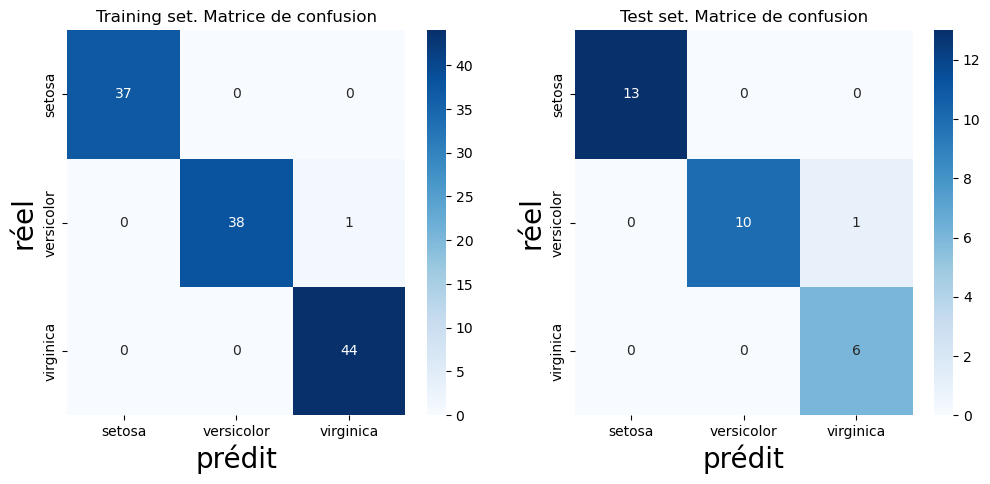

In [22]:
# entrez ci-dessous votre code python
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
import seaborn as sns

cm_labels = dfi['species'].unique()
cm_tr = confusion_matrix(np.argmax(y_train.to_numpy(),axis=1), np.argmax(y_train_hat,axis=1))
cm_tt = confusion_matrix(np.argmax(y_test.to_numpy(),axis=1), np.argmax(y_test_hat,axis=1))

fig=plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])

ax00 = fig.add_subplot(gs[0, 0], title="Training set. Matrice de confusion")
sns.heatmap(pd.DataFrame(cm_tr, columns=cm_labels, index=cm_labels), ax=ax00, cmap=plt.cm.Blues, annot = True)
ax00.set_xlabel("prédit", fontsize = 20)
ax00.set_ylabel("réel", fontsize = 20)

ax01=fig.add_subplot(gs[0, 1], title="Test set. Matrice de confusion")
sns.heatmap(pd.DataFrame(cm_tt, columns=cm_labels, index=cm_labels), ax=ax01, cmap=plt.cm.Blues, annot = True)
ax01.set_xlabel("prédit", fontsize = 20)
ax01.set_ylabel("réel", fontsize = 20)
plt.show()

fig.savefig("./svg-images/Iris3-ConfusionMatrix-petals-sepals.png")

### Bilan

<div class="warn">

Si tout s'est bien passé, vous avez trouvé des matrices de confusion proches du résultat ci-dessous :
    
<p><img width="950px" src="./svg-images/Iris3-ConfusionMatrix-petals-sepals-saved.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_MLIris_p"/></p>  

Il y a donc une nette amélioration par rapport à une IA qui a exploité deux descripteurs uniquement :
    
<p><img width="950px" src="../DS4B-svg/Iris3-ConfusionMatrix-petals-saved.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_MLIris_ps"/></p>  
    
**<span style="color:red"> Il n'y a pas d'amélioration ?</span>** Pas de chance. Relancez l'algorithme depuis le début
    
</div>

In [23]:
vID.end(cwd0)

**Fin à:** Thursday 03 November 2022, 21:41:43  
**Durée:** 00:00:12 452ms

<p style="text-align: center"><img width="800px" src="../config/svg/logoFin.svg" style="margin-left:auto; margin-right:auto"/></p>